# DSCI 552 Final Project

Name: Ziyue Chen

Github Username: zic115

USC ID: 8823457220

In [1]:
# Import packages
import splitfolders

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_e
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_v
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

# 1. Transfer Learning for Image Classification

## 1. (b) Data Exploration and Pre-processing

### 1. (b) ii. Generate the training set, validation set, and test set

In [2]:
# Generate the training set, validation set, and test test
input_folder = '../data/images'
output_folder = '../data/splited'
splitfolders.ratio(input_folder, output = output_folder, seed = 42, ratio = (0.715, 0.155, 0.13)) 

Copying files: 1176 files [00:00, 5189.67 files/s]


### 1. (b) i. Encode the classes using one-hot encoding & 1. (b) iii. Zero-pad or resize the images

In [3]:
# Load the images by defining label_mode and image_size
train = image_dataset_from_directory('../data/splited/train', label_mode = 'categorical', image_size = (224, 224), shuffle = False)
val = image_dataset_from_directory('../data/splited/val', label_mode = 'categorical', image_size = (224, 224), shuffle = False)
test = image_dataset_from_directory('../data/splited/test', label_mode = 'categorical', image_size = (224, 224), shuffle = False)

2022-12-10 22:31:25.777871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 827 files belonging to 20 classes.
Found 175 files belonging to 20 classes.
Found 174 files belonging to 20 classes.


## 1. (c) Transfer Learning

### 1. (c) ii. Perform image augmentation

In [4]:
# Use ImageDataGenerator to apply image augmentation
train_gen_e = ImageDataGenerator(preprocessing_function = preprocess_input_e,
                               zoom_range = 0.2,
                               rotation_range = 45,
                               horizontal_flip = True,
                               vertical_flip = False,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               brightness_range = [0.2,0.8])
train_gen_v = ImageDataGenerator(preprocessing_function = preprocess_input_v,
                               zoom_range = 0.2,
                               rotation_range = 45,
                               horizontal_flip = True,
                               vertical_flip = False,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               brightness_range = [0.2,0.8])

train_e = train_gen_e.flow_from_directory('../data/splited/train', target_size = (224, 224), class_mode = 'categorical', shuffle = False)
train_v = train_gen_v.flow_from_directory('../data/splited/train', target_size = (224, 224), class_mode = 'categorical', shuffle = False)

val_gen_e = ImageDataGenerator(preprocessing_function = preprocess_input_e)
val_gen_v = ImageDataGenerator(preprocessing_function = preprocess_input_v)

val_e = val_gen_e.flow_from_directory('../data/splited/val', target_size = (224, 224), class_mode = 'categorical', shuffle = False)
val_v = val_gen_v.flow_from_directory('../data/splited/val', target_size = (224, 224), class_mode = 'categorical', shuffle = False)

test_gen_e = ImageDataGenerator(preprocessing_function = preprocess_input_e)
test_gen_v = ImageDataGenerator(preprocessing_function = preprocess_input_v)

test_e = test_gen_e.flow_from_directory('../data/splited/test', target_size = (224, 224), class_mode = 'categorical', shuffle = False)
test_v = test_gen_v.flow_from_directory('../data/splited/test', target_size = (224, 224), class_mode = 'categorical', shuffle = False)


Found 827 images belonging to 20 classes.
Found 827 images belonging to 20 classes.
Found 175 images belonging to 20 classes.
Found 175 images belonging to 20 classes.
Found 174 images belonging to 20 classes.
Found 174 images belonging to 20 classes.


### 1. (c) iii. Modify the pre-trained EfficientNetB0 and VGG16 networks

In [5]:
# EfficientNetB0 - remove the last layer and freeze all layers before it
efficientnet = EfficientNetB0(weights = 'imagenet', input_shape = (224, 224, 3), include_top = False)
base_model_e = Model(efficientnet.input, efficientnet.layers[-2].output)
base_model_e.trainable = False

In [6]:
# EfficientNetB0 - add the ReLU activation function and the softmax layer
model_e = Sequential([base_model_e])
model_e.add(GlobalAveragePooling2D())
model_e.add(BatchNormalization())
model_e.add(Dense(100, activation = 'relu'))
model_e.add(Dropout(0.2))
model_e.add(Dense(20, activation = 'softmax'))
model_e.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [7]:
# VGG16 - remove the last layer and freeze all layers before it
vgg = VGG16(weights = 'imagenet', input_shape = (224, 224, 3), include_top = False)
base_model_v = Model(vgg.input, vgg.layers[-2].output)
base_model_v.trainable = False

In [8]:
# VGG16 - add the ReLU activation function and the softmax layer
model_v = Sequential([base_model_v])
model_v.add(GlobalAveragePooling2D())
model_v.add(BatchNormalization())
model_v.add(Dense(100, activation = 'relu'))
model_v.add(Dropout(0.2))
model_v.add(Dense(20, activation = 'softmax'))
model_v.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### 1. (c). iv. Train the modified EfficientNetB0 and VGG16 networks

In [9]:
# EfficientNetB0 - train the network
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
history_e = model_e.fit(train_e, epochs = 100, batch_size = 5, validation_data = val_e, callbacks = [early_stopping])

Epoch 1/100
26/26 [==============================] - 22s 732ms/step - loss: 4.0781 - accuracy: 0.0459 - val_loss: 3.4717 - val_accuracy: 0.1829
Epoch 2/100
26/26 [==============================] - 19s 702ms/step - loss: 3.2043 - accuracy: 0.1294 - val_loss: 2.7908 - val_accuracy: 0.2800
Epoch 3/100
26/26 [==============================] - 19s 705ms/step - loss: 2.7325 - accuracy: 0.2116 - val_loss: 1.8974 - val_accuracy: 0.4571
Epoch 4/100
26/26 [==============================] - 19s 704ms/step - loss: 2.4252 - accuracy: 0.3156 - val_loss: 1.6308 - val_accuracy: 0.5314
Epoch 5/100
26/26 [==============================] - 19s 714ms/step - loss: 2.3491 - accuracy: 0.3204 - val_loss: 1.4060 - val_accuracy: 0.5657
Epoch 6/100
26/26 [==============================] - 19s 709ms/step - loss: 2.2205 - accuracy: 0.3591 - val_loss: 1.2663 - val_accuracy: 0.6114
Epoch 7/100
26/26 [==============================] - 19s 704ms/step - loss: 2.0810 - accuracy: 0.3978 - val_loss: 1.2116 - val_accuracy:

In [10]:
# EfficientNetB0 - extract training and validation errors
training_acc_e = history_e.history['accuracy']
val_acc_e = history_e.history['val_accuracy']

training_err_e = []
val_err_e = []
for i in range(len(training_acc_e)):
    training_err_e.append(1 - training_acc_e[i])
    val_err_e.append(1 - val_acc_e[i])

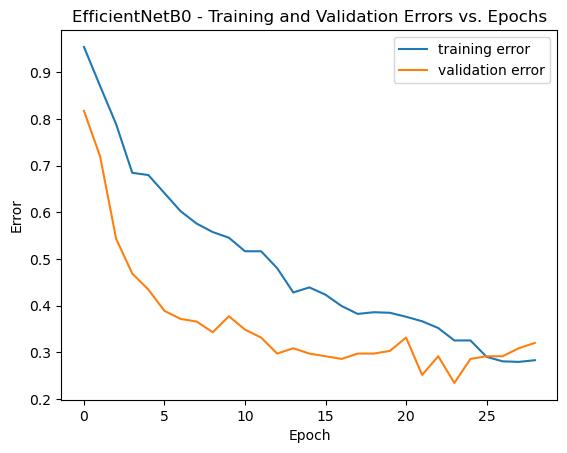

In [11]:
# EfficientNetB0 - plot training and validation errors vs. epochs
plt.plot(training_err_e, label = 'training error')
plt.plot(val_err_e, label = 'validation error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(loc = 'upper right')
plt.title('EfficientNetB0 - Training and Validation Errors vs. Epochs')
plt.show()

In [12]:
# VGG16 - train the network
history_v = model_v.fit(train_v, epochs = 100, batch_size = 5, validation_data = val_v, callbacks = [early_stopping])

Epoch 1/100
26/26 [==============================] - 191s 7s/step - loss: 3.8135 - accuracy: 0.0435 - val_loss: 3.9841 - val_accuracy: 0.1429
Epoch 2/100
26/26 [==============================] - 191s 7s/step - loss: 3.3211 - accuracy: 0.0641 - val_loss: 2.8608 - val_accuracy: 0.2343
Epoch 3/100
26/26 [==============================] - 192s 7s/step - loss: 3.1061 - accuracy: 0.1028 - val_loss: 2.4683 - val_accuracy: 0.2971
Epoch 4/100
26/26 [==============================] - 192s 7s/step - loss: 2.9542 - accuracy: 0.1306 - val_loss: 2.2644 - val_accuracy: 0.3314
Epoch 5/100
26/26 [==============================] - 192s 7s/step - loss: 2.8127 - accuracy: 0.1826 - val_loss: 2.1349 - val_accuracy: 0.3657
Epoch 6/100
26/26 [==============================] - 193s 7s/step - loss: 2.7031 - accuracy: 0.2056 - val_loss: 1.9386 - val_accuracy: 0.3943
Epoch 7/100
26/26 [==============================] - 193s 7s/step - loss: 2.6117 - accuracy: 0.2273 - val_loss: 1.8531 - val_accuracy: 0.4800
Epoch 

In [13]:
# VGG16 - extract training and validation errors
training_acc_v = history_v.history['accuracy']
val_acc_v = history_v.history['val_accuracy']

training_err_v = []
val_err_v = []
for i in range(len(training_acc_v)):
    training_err_v.append(1 - training_acc_v[i])
    val_err_v.append(1 - val_acc_v[i])

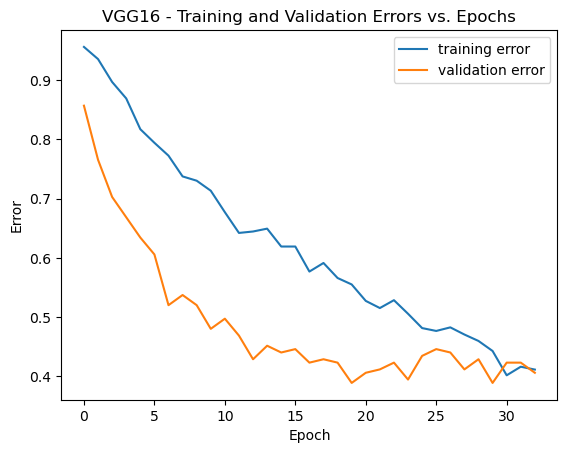

In [14]:
# VGG16 - plot training and validation errors vs. epochs
plt.plot(training_err_v, label = 'training error')
plt.plot(val_err_v, label = 'validation error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(loc = 'upper right')
plt.title('VGG16 - Training and Validation Errors vs. Epochs')
plt.show()

### 1. (c) v. Report Precision, Recall, and F1 score

In [15]:
# EfficientNetB0 - test the network
y_pred = model_e.predict(test)
y_pred = np.argmax(y_pred, axis = 1)

6/6 [==============================] - 4s 476ms/step


In [16]:
# EfficientNetB0 - precision, recall, F1 score
print(classification_report(test_e.classes, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       1.00      0.78      0.88         9
           2       0.64      1.00      0.78         9
           3       0.38      0.62      0.48         8
           4       1.00      0.22      0.36         9
           5       1.00      0.56      0.71         9
           6       0.75      1.00      0.86         9
           7       0.67      0.67      0.67         9
           8       0.69      1.00      0.82         9
           9       0.89      0.89      0.89         9
          10       0.88      0.78      0.82         9
          11       0.75      1.00      0.86         9
          12       0.50      0.56      0.53         9
          13       0.80      0.44      0.57         9
          14       0.54      0.78      0.64         9
          15       0.62      0.62      0.62         8
          16       0.82      1.00      0.90         9
          17       0.50    

In [19]:
# VGG16 - test the network
y_pred = model_v.predict(test)
y_pred = np.argmax(y_pred, axis = 1)

6/6 [==============================] - 32s 5s/step


In [20]:
# VGG16 - precision, recall, F1 score
print(classification_report(test_v.classes, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.46      0.67      0.55         9
           2       0.17      0.33      0.22         9
           3       0.17      0.12      0.14         8
           4       0.33      0.11      0.17         9
           5       0.17      0.22      0.19         9
           6       0.29      0.22      0.25         9
           7       0.35      0.67      0.46         9
           8       0.67      0.67      0.67         9
           9       0.78      0.78      0.78         9
          10       0.33      0.11      0.17         9
          11       0.54      0.78      0.64         9
          12       0.22      0.22      0.22         9
          13       0.20      0.11      0.14         9
          14       0.00      0.00      0.00         9
          15       0.25      0.12      0.17         8
          16       0.29      0.67      0.40         9
          17       0.27    